In [1]:
%%html
<style>
div.optional {
    display: block;
    background-color: #d7e2ff;
    border-color: #d7e2ff;
    border-left: 5px solid #d7e2ff;
    padding: 0.5em;
}
div.advanced {
    display: block;
    background-color: #fff4d7;
    border-color: #fff4d7;
    border-left: 5px solid #fff4d7;
    padding: 0.5em;
}
</style>

# Computational Mathematics  <a class="tocSkip">

## PDE solvers (intro to finite differences) <a class="tocSkip">
    
### Homework Exercises  <a class="tocSkip">

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Homework" data-toc-modified-id="Homework-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Homework</a></span><ul class="toc-item"><li><span><a href="#Homework---Upwind-vs-central-discretrisation" data-toc-modified-id="Homework---Upwind-vs-central-discretrisation-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Homework - Upwind vs central discretrisation</a></span></li><li><span><a href="#Homework---Larger-stencils-/-higher-orders-of-accuracy-[$\star\star$]" data-toc-modified-id="Homework---Larger-stencils-/-higher-orders-of-accuracy-[$\star\star$]-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Homework - Larger stencils / higher orders of accuracy [$\star\star$]</a></span></li><li><span><a href="#Homework---An-analytical-solution-to-advection-diffusion" data-toc-modified-id="Homework---An-analytical-solution-to-advection-diffusion-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Homework - An analytical solution to advection-diffusion</a></span></li><li><span><a href="#Homework---Pure-advection---impact-of-time-step" data-toc-modified-id="Homework---Pure-advection---impact-of-time-step-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Homework - Pure advection - impact of time step</a></span></li></ul></li></ul></div>

In [2]:
%matplotlib inline
import numpy as np
import scipy.linalg as sl
# we'll start using sparse matrices here
import scipy.sparse as sp
# and linear algebra functions designed for sparse matrices
import scipy.sparse.linalg as spla
import matplotlib.pyplot as plt
# the following allows us to plot triangles indicating convergence order
from mpltools import annotation

# font sizes for plots
plt.rcParams['font.size'] = 12
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial', 'Dejavu Sans']

# Homework

## Homework - Upwind vs central discretrisation

Use our codes `BVP_AD_central` and `BVP_AD_upwind` to compute and plot error convergence for these two schemes for our test problem from the lecture with a Peclet number of 10.
    
Hence, establish that even though the upwind scheme is coupled with a second-order scheme for diffusion, it is the first-order contribution to the overall error which ultimately dominates and so the overall scheme is only first-order accurate.


In [89]:
kappa = 0.005
L = 1
Pe = 10
U = Pe * kappa / L
CE = 1

In [90]:
def BVP_AD_central(L, U, kappa, CE, N):
    """ function to assemble and solve the AD BVP problem
    using central differences for diff. backward for advection. 
    
    Returns the mesh x and the solution C
    """
    dx = L / N
    x = np.linspace(-dx / 2, dx / 2 + L, N + 2)
    A = np.zeros((N + 2, N + 2))
    b = np.zeros((N + 2))
    # interior points
    r_diff = kappa / dx**2
    r_adv = 0.5 * U / dx
    for i in range(1, N + 1):
        A[i, i - 1] = r_diff + r_adv
        A[i, i] = -2 * r_diff
        A[i, i + 1] = r_diff - r_adv
        b[i] = 0
    # BC1
    A[0, 0] = 0.5
    A[0, 1] = 0.5
    b[0] = 0
    # BC2
    A[N + 1, N] = 0.5
    A[N + 1, N + 1] = 0.5
    b[N + 1] = CE  # BC2
    # invert matrix
    C = np.linalg.solve(A, b)
    return x, C

def BVP_AD_upwind(L, U, kappa, CE, N):
    """ function to assemble and solve the AD BVP problem
    using central differences for diff. and backward for adv.
    """
    dx = L / N
    x = np.linspace(-dx / 2, dx / 2 + L, N + 2)
    A = np.zeros((N + 2, N + 2))
    b = np.zeros((N + 2))
    # interior points
    r_diff = kappa / dx**2
    r_adv = U / dx
    for i in range(1, N + 1):
        A[i, i - 1] = r_diff + r_adv
        A[i, i] = -2 * r_diff - r_adv
        A[i, i + 1] = r_diff
        b[i] = 0
    # BC1
    A[0, 0] = 0.5
    A[0, 1] = 0.5
    b[0] = 0
    # BC2
    A[N + 1, N] = 0.5
    A[N + 1, N + 1] = 0.5
    b[N + 1] = CE  # BC2
    # invert matrix
    C = np.linalg.solve(A, b)
    return x, C

In [121]:
err_cc = []
err_cu = []

#solution with BVP_central
for i in [32, 64, 128, 256, 512, 1024]:
    x, Cc = BVP_AD_central(L, U, kappa, CE, i)
    x, Cu = BVP_AD_upwind(L, U, kappa, CE, i)
    
    Cex = CE * (np.exp(Pe * x / L) - 1) / (np.exp(Pe) - 1)
    
    err_cc.append(np.linalg.norm(Cex - Cc)/np.sqrt(len(x)))
    err_cu.append(np.linalg.norm(Cex - Cu)/np.sqrt(len(x)))

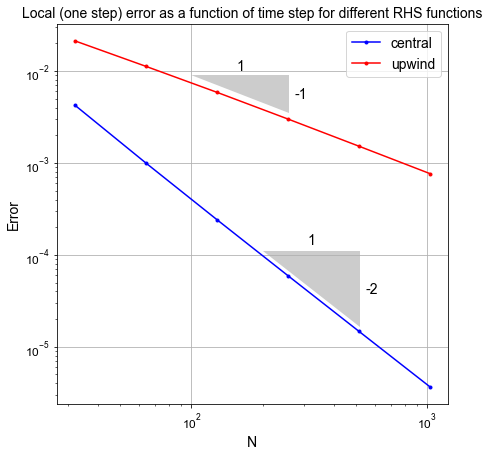

In [128]:
fig = plt.figure(figsize=(7, 7))
ax1 = plt.subplot(111)
ax1.loglog([32, 64, 128, 256, 512, 1024], err_cc, 'b.-', label = 'central')
ax1.loglog([32, 64, 128, 256, 512, 1024], err_cu, 'r.-', label = 'upwind')
ax1.set_xlabel('N', fontsize = 14)
ax1.set_ylabel('Error', fontsize = 14)
ax1.set_title('Local (one step) error as a function of time step for different RHS functions', 
              fontsize = 14)
ax1.grid(True)
ax1.legend(loc='best', fontsize = 14)
annotation.slope_marker((2e2, 1.1e-4), (-2, 1), ax=ax1,
                        size_frac=0.25, pad_frac=0.05, text_kwargs = dict(fontsize = 14))
annotation.slope_marker((1e2, 9e-3), (-1, 1), ax=ax1,
                        size_frac=0.25, pad_frac=0.05, text_kwargs = dict(fontsize = 14))

<div class="advanced">

## Homework - Larger stencils / higher orders of accuracy [$\star\star$]

We saw in the lecture first- and second-order approximations to the first derivative.

By making use of more points (expanding the stencil) it is possible to come up with approximations of arbitrary order.

Tables of coefficients, assuming a uniform mesh, can be found at:
<https://en.wikipedia.org/wiki/Finite_difference_coefficient>

Try expanding our example from the lecture where we computed the first derivative of $\sin(x)$ at the location $x=0.8$ and plotted the error as a function of $\Delta x$, with some other examples of finite difference stencils from the tables at that web page.

[NB. the part of the question above is quite simple - in the sample solution I demonstrate an implementation of the third order accurate scheme; the part of the question below is more complicated].

Note that in the section of that web page titled "Arbitrary stencil points" it also gives a matrix system which can be solved for the finite difference coefficients which provides an approximation of arbitrary order derivatices on an arbitrary stencil. 

For a more in-depth description and derivation take a look at: <http://web.media.mit.edu/~crtaylor/calculator.html>
(click on "How does it work?").

Write some code to construct and solve this matrix system, and hence extend the convergence plot we presented above for the first derivative of $\sin(x)$ and $x=0.8$ for orders 1-6.

</div>

## Homework - An analytical solution to advection-diffusion

An exact solution to the advection-diffusion equation is given by


$$ c(x,t) = \frac{1}{\sqrt{4\pi \, \kappa \,t}}\exp\left  (-\frac{(x-Ut)^2}{4\kappa \, t}\right).$$


1. Note that this holds in an infinite domain - we can make use of it only as long as our numerical solution is far away from boundaries, or in a periodic domain as long as the solution behaviour does not start to encroach on itself.


2. The initial condition that this solution corresponds to is a [Dirac-delta function](https://en.wikipedia.org/wiki/Dirac_delta_function). We clearly can't represent this on our mesh as it has infinitesimal thickness - all sorts of problems would arise if we tried to. But what we can do is assume that our simulation starts at some $t>0$ and initialise our problem with the corresponding exact solution (which for $t>0$ is a Gaussian and for sufficiently large times can be represented on our mesh).


Write a function to evaluate this exact analytical solution and use it to initialise a simulation and plot a comparison between the exact and analytical solution at later times.

I suggest you use periodic boundary conditions (e.g. your starting point could be our function from the lecture `solve_adv_diff_Gaussian2`).

First try selecting some appropriate physical and numerical parameters such that you have a stable solution and avoid boundaries. Then try refining the spatial and temporal mesh to see if your solution gets closer to the exact solution.

In [149]:
def adv_diff_analytical_solution(U, kappa, x0, x, t):
    """ Analtical solution to advection-diffusion for an assumed 
    Dirac-delta initial condition at t=0.
    """
    return np.exp( -((x-x0) - U*t)**2 / (4.*kappa*t)) / np.sqrt(4. * np.pi * kappa * t)

In [237]:
U = 1
kappa = 1/100.
N = 500
L = 10.
dx = L / N
dt = 0.02
t_start = 2.
t_end = t_start + 4.
x0 = 1.0

def adv_central_periodic(N):
    # advection - periodic
    Dx = 0.5*np.eye(N, k=1) - 0.5*np.eye(N, k=-1)
    # Add in the wrapped values due to periodicity
    Dx[0, -1] = -0.5
    Dx[-1, 0] = 0.5
    return Dx

def diff_central_periodic(N):
    # diffusion - periodic
    Dxx = np.eye(N, k=1) - 2*np.eye(N) + np.eye(N, k=-1)
    # Add in the wrapped values due to periodicity
    Dxx[0, -1] = 1
    Dxx[-1, 0] = 1
    return Dxx

dx = L / N
x = np.linspace(0, L, N)
Dx = adv_central_periodic(N)
Dxx = diff_central_periodic(N)   
A = -(U / dx) * Dx + (kappa / dx**2) * Dxx

In [238]:
t = np.arange(t_start, t_end, dt)
C = np.empty((len(x), len(t)))
    
# define an initial condition
C[:,0] = adv_diff_analytical_solution(U, kappa, x0, x, t_start)

In [239]:
I = np.eye(len(x))
for n in range(len(t)-1):
    C[:,n+1] = (I + A * dt) @ C[:,n]

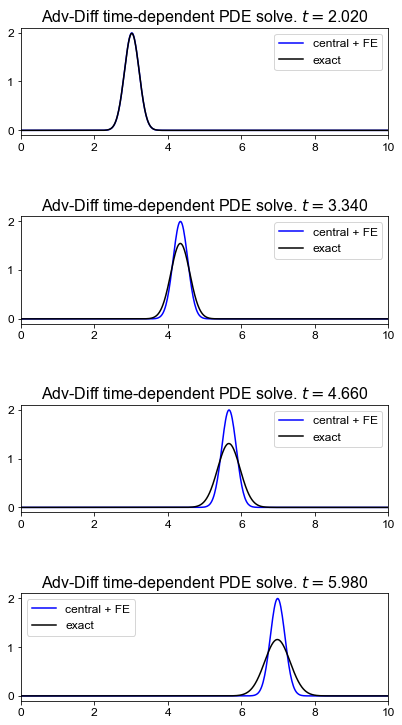

In [240]:
# set up figure
fig, axs = plt.subplots(4, 1, figsize=(6, 10))
axs = axs.reshape(-1)
fig.tight_layout(w_pad=4, h_pad=5)
xf = np.linspace(0, L, 1000)
for i, n in enumerate(np.linspace(1,C.shape[1]-1,4, dtype=int)):
    axs[i].plot(x, C[:,n], 'b-', label='central + FE')
    axs[i].plot(xf, adv_diff_analytical_solution(U, kappa, x0, xf, t[n]), 'k-', label='exact')
    axs[i].legend(loc='best')
    axs[i].set_xlim(0.0, 10.0)
    axs[i].set_ylim(-0.1, 2.1)
    axs[i].set_title('Adv-Diff time-dependent PDE solve. $t=${0:.3f}'.format(t[n]), fontsize=16)

## Homework - Pure advection - impact of time step

Write a solver for a pure advection problem in a periodic domain using forward Euler with upwind differences in space and with a Gaussian initial condition.

First test that it works/fails based on the CFL condition.

Then update the solver such that it selects the timestep automatically to satisfy a user-defined target Courant number, e.g. look to enforce a Courant number of 0.8.

CFL:  0.20000
CFL:  0.40000
CFL:  0.80000
CFL:  1.60000


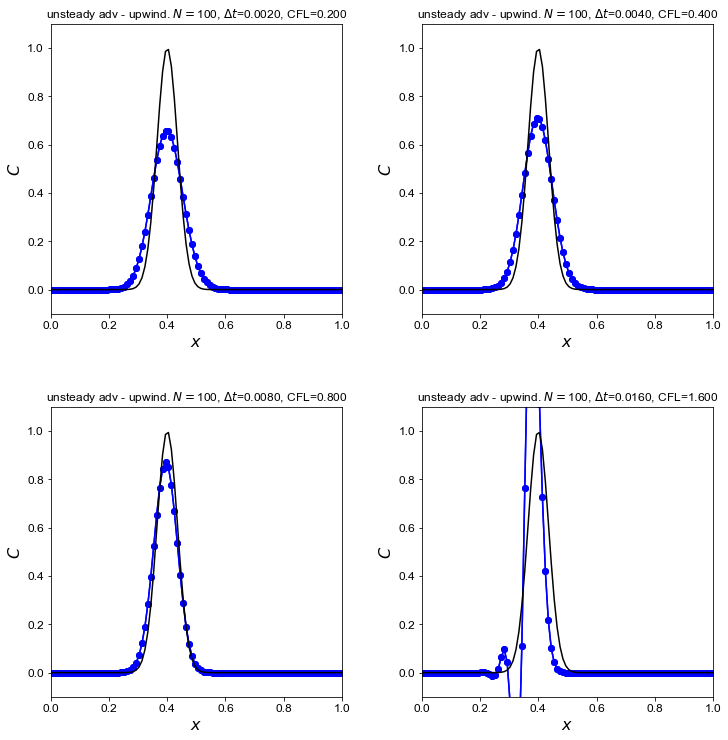

In [244]:
def adv_upwind_periodic(N):
    # advection - periodic
    Dx = np.eye(N, k=0) - np.eye(N, k=-1)
    # Add in the wrapped value due to periodicity
    Dx[0, -1] = -1
    return Dx

# physical parameters
L = 1
U = 1

def solve_adv_upwind(N, dt, t_start, t_end, U):
    # define spatial mesh
    dx = L / N
    x = np.linspace(0, L, N)

    # create discrerisation matrix
    Dx = adv_upwind_periodic(N)
    A = -(U / dx) * Dx

    # time step using forward Euler - refer back to IVP lecture for details
    print('CFL:  {0:.5f}'.format(U*dt/dx))

    t = np.arange(t_start, t_end, dt)

    C = np.empty((len(x), 1))
    # define an initial condition
    C = np.exp(-((x-0.2)/0.05)**2)
    I = np.eye(len(x))
    for n in range(len(t)-1):
        C_prev = np.copy(C)
        C = (I + A * dt) @ C_prev
    return C, x


# set up figure with 4 subplots to plot 4 resolutions
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
# reshape so that we can iterate below over axs[i] instead of ax[i,j]
axs = axs.reshape(-1)
fig.tight_layout(w_pad=4, h_pad=6)

# let's compute solution and plot for 4 different time steps
N = 100
t_end = 0.2
for i, dt in enumerate((0.002, 0.004, 0.008, 0.016)):
    # call function to generate numerical solution
    C, x = solve_adv_upwind(N, dt, 0.0, t_end, U)
    axs[i].plot(x, C, 'bo-')
    axs[i].plot(x, C, 'bo-', x, np.exp(-(((x-U*t_end)-0.2)/0.05)**2), 'k')
    axs[i].set_xlabel('$x$', fontsize=16)
    axs[i].set_ylabel('$C$', fontsize=16)
    axs[i].set_title(
        'unsteady adv - upwind. $N=${0:3d}, $\Delta t$={1:.4f}, CFL={2:.3f}'.format(N, dt, U*dt/(L / N)), fontsize=12)
    axs[i].set_xlim(0, 1)
    axs[i].set_ylim(-0.1, 1.1)